# Preprocessing data

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
# Download database
df = pd.read_excel('online_retail.xlsx')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    

In [4]:
# correct column types
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)
df['Country'] = df['Country'].astype(str)

In [5]:
df = df.drop_duplicates()
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]   # remove useless data
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']     # an interesting information
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132186
Country             0
TotalPrice          0
dtype: int64

In [6]:
proportion = df.isna().sum()[6]/len(df)
print(proportion)

0.2518413802826562


/var/folders/d0/_q_kz2l15k34b1whgk26rv_h0000gn/T/ipykernel_23977/2343491170.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  proportion = df.isna().sum()[6]/len(df)


The CustomerID column contains a significant proportion of null values (25%).

Let's examine if there are any patterns or anomalies where the rows have a null CustomerID.

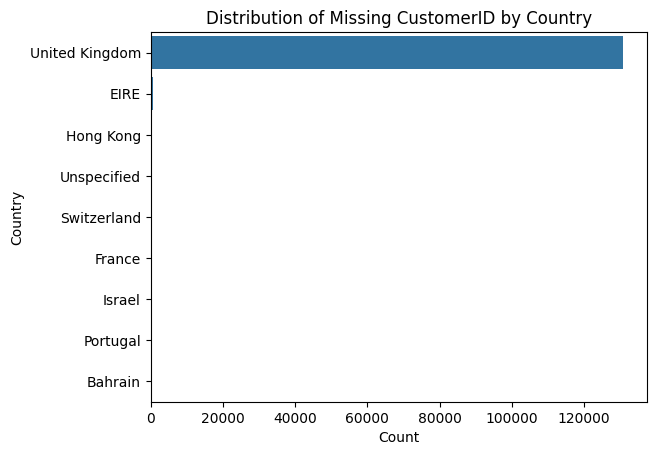

In [7]:
df_customer_nan = df[df['CustomerID'].isna()]

# check the country distribution
sns.countplot(data=df_customer_nan, y='Country', order=df_customer_nan['Country'].value_counts().index)
plt.title('Distribution of Missing CustomerID by Country')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()


In [8]:
df_customer_nan['Country'].value_counts()

Country
United Kingdom    130782
EIRE                 653
Hong Kong            280
Unspecified          201
Switzerland          117
France                66
Israel                47
Portugal              39
Bahrain                1
Name: count, dtype: int64

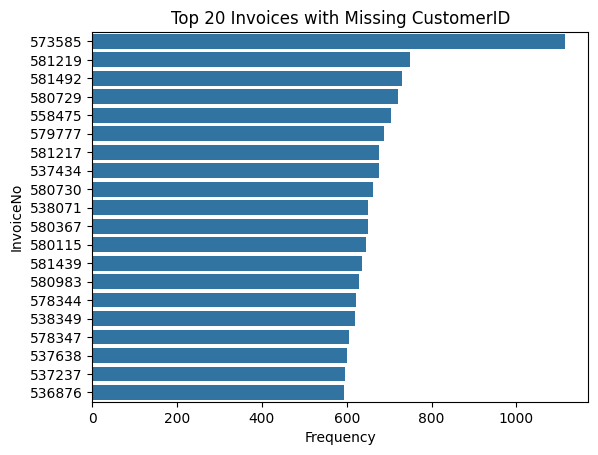

In [9]:
# countplot for invoice distribution (Categorical Analysis)
sns.countplot(data=df_customer_nan, y='InvoiceNo', order=df_customer_nan['InvoiceNo'].value_counts().index[:20])
plt.title('Top 20 Invoices with Missing CustomerID')
plt.xlabel('Frequency')
plt.ylabel('InvoiceNo')
plt.show()

In [10]:
df_customer_nan[df_customer_nan['InvoiceNo'] == '573585']['Description']

430237           ASSTD DESIGN RACING CAR PEN
430238             ASSORTED COLOURS SILK FAN
430239                        SANDALWOOD FAN
430240               EDWARDIAN PARASOL BLACK
430241             EDWARDIAN PARASOL NATURAL
                         ...                
431346           PINK ENAMEL+GLASS HAIR COMB
431347             LETTER "S" BLING KEY RING
431348                        DOTCOM POSTAGE
431349    Dotcomgiftshop Gift Voucher £20.00
431350               WALL ART LOVES' SECRET 
Name: Description, Length: 1114, dtype: object

As we can see, there is a pattern between Country and the null CustomerID. Most of the null values are related to the United Kingdom, and the highest frequency is with the InvoiceNo 573585.

Given this consistent amount, I will split the dataset into two subsets: one including CustomerID and another excluding it. This approach allows me to leverage the full dataset for insights that don't require the ID while using the reduced dataset for analyses that depend on it.

In [11]:
df_customer = df.dropna(subset=['CustomerID'])

df_no_customer = df.drop(['CustomerID'], axis=1)

And what if we can deduce the CustomerID by considering the InvoiceNo?

In [12]:
# check if each InvoiceNo corresponds to a unique CustomerID
invoice_correlation = df.groupby('InvoiceNo')['CustomerID'].nunique()

# display InvoiceNo with multiple CustomerIDs
multiple_customers = invoice_correlation[invoice_correlation > 1]
print("Invoices with multiple CustomerIDs:")
print(multiple_customers)

# If no InvoiceNo has multiple CustomerIDs, proceed to impute
if multiple_customers.empty:
    # Create a mapping of InvoiceNo to CustomerID
    invoice_to_customer = df_customer.set_index('InvoiceNo')['CustomerID'].to_dict()

    # Impute missing CustomerID based on InvoiceNo
    df_no_customer['CustomerID'] = df_no_customer['InvoiceNo'].map(invoice_to_customer)

    # Combine back the dataframes
    df_combined = pd.concat([df_customer, df_no_customer], ignore_index=True)
else:
    print("Some invoices have multiple CustomerIDs; imputation not possible.")


Invoices with multiple CustomerIDs:
Series([], Name: CustomerID, dtype: int64)


We don't have multiple CustomerIDs with the same InvoiceNo

In [13]:
# check if we affected the rows

# create mapping of InvoiceNo to CustomerID
invoice_to_customer = df_customer.set_index('InvoiceNo')['CustomerID'].to_dict()

# impute missing CustomerID based on InvoiceNo
df_no_customer['CustomerID'] = df_no_customer['InvoiceNo'].map(invoice_to_customer)

# combine the dataframes
df_combined = pd.concat([df_customer, df_no_customer], ignore_index=True)

print(f"Total rows after combining: {df_combined.shape[0]}")
print(f"Remaining missing CustomerID: {df_combined['CustomerID'].isna().sum()}")

Total rows after combining: 917570
Remaining missing CustomerID: 132186


As we can see, we didn't drop any rows by mapping but the number of missing values remains the same. We can deduce that these InvoiceNo values exist only in rows without CustomerID and were not present in the rows with CustomerID.

# First group of insights (without CustomerID information)

Top-Selling Products

                             Description  Quantity
2387         PAPER CRAFT , LITTLE BIRDIE     80995
2052      MEDIUM CERAMIC TOP STORAGE JAR     78033
3934   WORLD WAR 2 GLIDERS ASSTD DESIGNS     54951
1816             JUMBO BAG RED RETROSPOT     48371
3844  WHITE HANGING HEART T-LIGHT HOLDER     37872
2681                      POPCORN HOLDER     36749
2337     PACK OF 72 RETROSPOT CAKE CASES     36396
227        ASSORTED COLOUR BIRD ORNAMENT     36362
2741                  RABBIT NIGHT LIGHT     30739
2107             MINI PAINT SET VINTAGE      26633


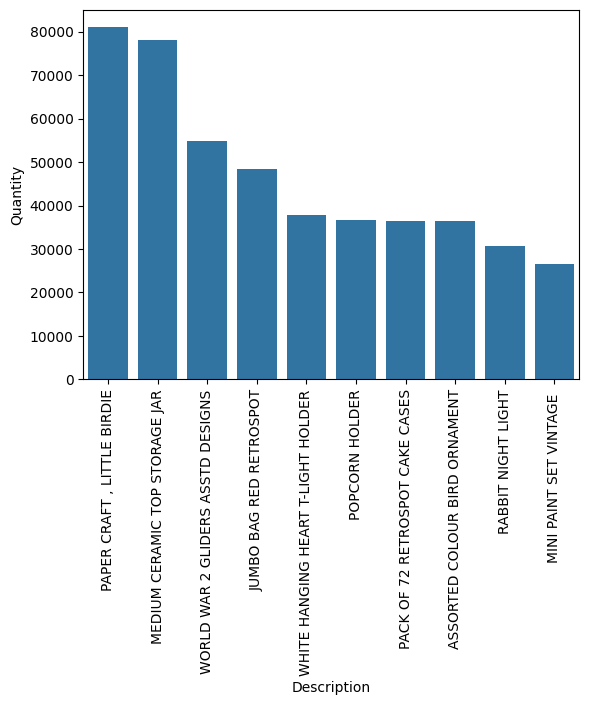

In [14]:
# PRODUCTS WITH THE HIGHEST TOTAL SALES (BASED ON QUANTITY)

top_products = df_no_customer.groupby('Description', as_index=False)['Quantity'].sum().sort_values('Quantity', ascending=False).head(10)
sns.barplot(data=top_products, x='Description', y='Quantity')
plt.xticks(rotation=90)
print(top_products)

Revenue Trends Over Time

InvoiceDate
2010-12-01     58776.79
2010-12-02     47629.42
2010-12-03     46898.63
2010-12-05     31364.63
2010-12-06     54624.15
                ...    
2011-12-05     88620.84
2011-12-06     56558.83
2011-12-07     75315.55
2011-12-08     82371.55
2011-12-09    200900.98
Name: TotalPrice, Length: 305, dtype: float64


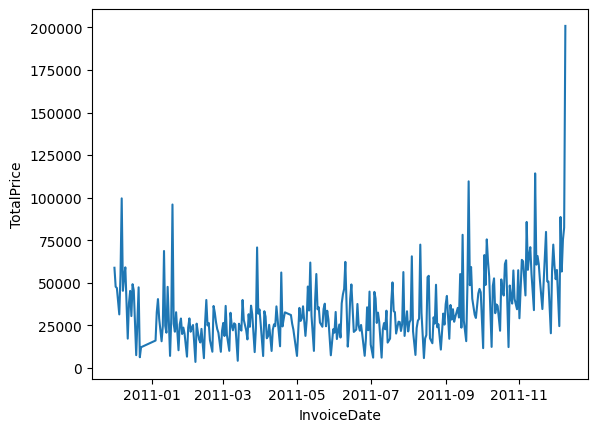

In [15]:
# DAILY OR MONTHLY REVENUE TRENDS

revenue_trend = df.groupby(df_no_customer['InvoiceDate'].dt.date)['TotalPrice'].sum()
print(revenue_trend)
sns.lineplot(data=revenue_trend)
plt.show()

Most Active Countries by Sales

           Country  Quantity
36  United Kingdom   4646906
24     Netherlands    200361
10            EIRE    147007
14         Germany    119154
13          France    112060
0        Australia     83891
32          Sweden     36078
33     Switzerland     30617
31           Spain     27933
20           Japan     26016


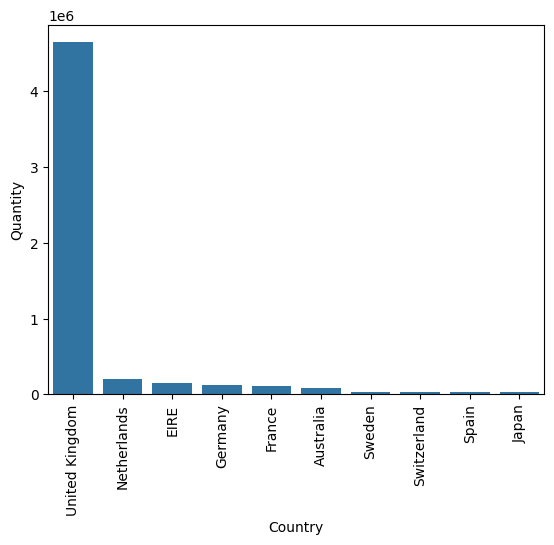

In [16]:
# COUNTRIES WITH THE HIGHEST TOTAL QUANTITY SOLD

top_countries = df_no_customer.groupby('Country', as_index=False)['Quantity'].sum().sort_values('Quantity', ascending=False).head(10)
print(top_countries)

sns.barplot(data=top_countries, x='Country', y='Quantity')
plt.xticks(rotation=90)
plt.show()

Average Order Size

In [17]:
# AVERAGE QUANTITY OF ITEMS PER TRANSACTION

average_order_size = df_no_customer['Quantity'].mean()
print(average_order_size)

10.616600429052085


High-Value Transactions

In [18]:
# 5 TRANSACTIONS WITH THE HIGHEST REVENUE (TotalPrice)

high_value_transactions = df_no_customer.sort_values('TotalPrice', ascending=False)[['InvoiceNo', 'Description', 'Quantity', 'UnitPrice','Country', 'TotalPrice']].head(5)
print(high_value_transactions)

       InvoiceNo                     Description  Quantity  UnitPrice  \
540421    581483     PAPER CRAFT , LITTLE BIRDIE     80995       2.08   
61619     541431  MEDIUM CERAMIC TOP STORAGE JAR     74215       1.04   
222680    556444  PICNIC BASKET WICKER 60 PIECES        60     649.50   
15017     537632                      AMAZON FEE         1   13541.33   
299982   A563185                 Adjust bad debt         1   11062.06   

               Country  TotalPrice  
540421  United Kingdom   168469.60  
61619   United Kingdom    77183.60  
222680  United Kingdom    38970.00  
15017   United Kingdom    13541.33  
299982  United Kingdom    11062.06  


Sales Distribution by Product

In [19]:
# UNDERSTAND THE CONTRIBUTION OF THE TOP 5 PRODUCTS TO OVERALL SALES

product_sales_share = df_no_customer.groupby('Description')['TotalPrice'].sum() / df['TotalPrice'].sum()
print(product_sales_share.sort_values(ascending=False).head())

Description
DOTCOM POSTAGE                        0.019380
REGENCY CAKESTAND 3 TIER              0.016365
PAPER CRAFT , LITTLE BIRDIE           0.015830
WHITE HANGING HEART T-LIGHT HOLDER    0.009983
PARTY BUNTING                         0.009345
Name: TotalPrice, dtype: float64


# Second group of insights (considering the CustomerID information)

As observed during preprocessing, removing the missing values in the CustomerID column may introduce biases. For instance, this approach could exclude a substantial amount of data associated with the United Kingdom, which is also the Country who sells the most (check the first insights).

Customer Lifetime Value (CLV)

In [22]:
clv = df_customer.groupby('CustomerID')['TotalPrice'].sum().reset_index()
clv.rename(columns={'TotalPrice': 'CustomerLifetimeValue'}, inplace=True)
print(clv)

      CustomerID  CustomerLifetimeValue
0        12346.0               77183.60
1        12347.0                4310.00
2        12348.0                1797.24
3        12349.0                1757.55
4        12350.0                 334.40
...          ...                    ...
4333     18280.0                 180.60
4334     18281.0                  80.82
4335     18282.0                 178.05
4336     18283.0                2045.53
4337     18287.0                1837.28

[4338 rows x 2 columns]


Recency, Frequency, and Monetary (RFM) Analysis

In [24]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
'InvoiceNo': 'nunique',  # Frequency
'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.rename(columns={
'InvoiceDate': 'Recency',
'InvoiceNo': 'Frequency',
'TotalPrice': 'Monetary'
}, inplace=True)
print(rfm)


      CustomerID  Recency  Frequency  Monetary
0        12346.0      326          1  77183.60
1        12347.0        2          7   4310.00
2        12348.0       75          4   1797.24
3        12349.0       19          1   1757.55
4        12350.0      310          1    334.40
...          ...      ...        ...       ...
4333     18280.0      278          1    180.60
4334     18281.0      181          1     80.82
4335     18282.0        8          2    178.05
4336     18283.0        4         16   2045.53
4337     18287.0       43          3   1837.28

[4338 rows x 4 columns]


Customer Segmentation (using RFM for clustering)

In [33]:
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x: (x - x.mean()) / x.std())
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print(rfm)

      CustomerID  Recency  Frequency  Monetary ChurnRisk  Cluster
0        12346.0      326          1  77183.60      High        3
1        12347.0        2          7   4310.00       Low        0
2        12348.0       75          4   1797.24       Low        0
3        12349.0       19          1   1757.55       Low        0
4        12350.0      310          1    334.40      High        1
...          ...      ...        ...       ...       ...      ...
4333     18280.0      278          1    180.60      High        1
4334     18281.0      181          1     80.82      High        1
4335     18282.0        8          2    178.05       Low        0
4336     18283.0        4         16   2045.53       Low        3
4337     18287.0       43          3   1837.28       Low        0

[4338 rows x 6 columns]


Churn Analysis (Customers with no recent purchases)

In [34]:
inactivity_threshold = 90 # threshold 90 days
rfm['ChurnRisk'] = rfm['Recency'].apply(lambda x: 'High' if x > inactivity_threshold else 'Low')
print(rfm)

      CustomerID  Recency  Frequency  Monetary ChurnRisk  Cluster
0        12346.0      326          1  77183.60      High        3
1        12347.0        2          7   4310.00       Low        0
2        12348.0       75          4   1797.24       Low        0
3        12349.0       19          1   1757.55       Low        0
4        12350.0      310          1    334.40      High        1
...          ...      ...        ...       ...       ...      ...
4333     18280.0      278          1    180.60      High        1
4334     18281.0      181          1     80.82      High        1
4335     18282.0        8          2    178.05       Low        0
4336     18283.0        4         16   2045.53       Low        3
4337     18287.0       43          3   1837.28       Low        0

[4338 rows x 6 columns]


Top Customers by Revenue


In [28]:
top_customers = clv.nlargest(10, 'CustomerLifetimeValue')
print(top_customers)

      CustomerID  CustomerLifetimeValue
1689     14646.0              280206.02
4201     18102.0              259657.30
3728     17450.0              194390.79
3008     16446.0              168472.50
1879     14911.0              143711.17
55       12415.0              124914.53
1333     14156.0              117210.08
3771     17511.0               91062.38
2702     16029.0               80850.84
0        12346.0               77183.60


Time Between Purchases

In [30]:
time_between = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.diff().mean()).reset_index()
time_between.rename(columns={'InvoiceDate': 'AvgTimeBetweenPurchases'}, inplace=True)
print(time_between)

      CustomerID   AvgTimeBetweenPurchases
0        12346.0                       NaT
1        12347.0 2 days 00:24:10.276243093
2        12348.0           9 days 10:12:08
3        12349.0           0 days 00:00:00
4        12350.0           0 days 00:00:00
...          ...                       ...
4333     18280.0           0 days 00:00:00
4334     18281.0           0 days 00:00:00
4335     18282.0          10 days 19:28:00
4336     18283.0           0 days 11:07:49
4337     18287.0 2 days 07:17:14.782608695

[4338 rows x 2 columns]


Retention Analysis

In [ ]:
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
retention = df.merge(first_purchase, on='CustomerID', suffixes=('', '_First'))
retention['Retention'] = (retention['InvoiceDate'] - retention['InvoiceDate_First']).dt.days
retention = retention[retention['Retention'] > 0]   # remove when the purchase is the same as the first one

print(retention[['CustomerID', 'InvoiceDate','InvoiceDate_First', 'Retention']])

        CustomerID         InvoiceDate   InvoiceDate_First  Retention
1908       17850.0 2010-12-02 08:32:00 2010-12-01 08:26:00          1
1909       17850.0 2010-12-02 08:32:00 2010-12-01 08:26:00          1
1910       17850.0 2010-12-02 08:32:00 2010-12-01 08:26:00          1
1911       17850.0 2010-12-02 08:32:00 2010-12-01 08:26:00          1
1912       17850.0 2010-12-02 08:32:00 2010-12-01 08:26:00          1
...            ...                 ...                 ...        ...
392687     12680.0 2011-12-09 12:50:00 2011-08-18 15:44:00        112
392688     12680.0 2011-12-09 12:50:00 2011-08-18 15:44:00        112
392689     12680.0 2011-12-09 12:50:00 2011-08-18 15:44:00        112
392690     12680.0 2011-12-09 12:50:00 2011-08-18 15:44:00        112
392691     12680.0 2011-12-09 12:50:00 2011-08-18 15:44:00        112

[287168 rows x 4 columns]
